<a href="https://colab.research.google.com/github/shu7620/Text_classification_CNN/blob/main/CNN_text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Imports**

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras import layers
from sklearn.metrics import confusion_matrix,classification_report

# **2. Load Data**

In [3]:
df=pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")
df=df.sample(n=5000).reset_index(drop=True)
df.head()

,review,sentiment
0,On the surface the idea of Omen 4 was good. It...,negative
1,"I attempted to watch this, and was highly disa...",negative
2,OK enough already. this is a terrible piece of...,negative
3,This movie was suspenseful and fun to view. As...,positive
4,"I can't imagine anyone would ever, in a millio...",negative


# **3. Preprocess Text**

In [4]:
import re
import html
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')

stemmer=PorterStemmer()
stopwords=set(stopwords.words("english"))

def clean_review_with_stopwords_and_stemming(review):
  review=html.unescape(review)
  review=re.sub(r'<.>*?','',review)

  review=review.lower()
  review=re.sub(r'[^a-z\s]','',review)

  words=review.split()

  cleaned_review=[stemmer.stem(word) for word in words if word not in stopwords]

  return ' '.join(cleaned_review)


df["review"]=df["review"].apply(clean_review_with_stopwords_and_stemming)

df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,review,sentiment
0,surfac idea omen good nice see devil child cou...,negative
1,attempt watch highli disappoint dont expect in...,negative
2,ok enough alreadi terribl piec televis camera ...,negative
3,movi suspens fun view fan type movi enjoy prem...,positive
4,cant imagin anyon would ever million year want...,negative
...,...,...
4995,ive fan heaven gate sinc first releas ive seen...,positive
4996,good start bit surpris find machineri quit adv...,positive
4997,great movi read brief synopsi unimpress watch ...,positive
4998,brain wouldnt die consid distast sever cut pas...,positive


# **4. Encoding**

In [5]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df["sentiment"]=le.fit_transform(df["sentiment"])
df

,review,sentiment
0,surfac idea omen good nice see devil child cou...,0
1,attempt watch highli disappoint dont expect in...,0
2,ok enough alreadi terribl piec televis camera ...,0
3,movi suspens fun view fan type movi enjoy prem...,1
4,cant imagin anyon would ever million year want...,0
...,...,...
4995,ive fan heaven gate sinc first releas ive seen...,1
4996,good start bit surpris find machineri quit adv...,1
4997,great movi read brief synopsi unimpress watch ...,1
4998,brain wouldnt die consid distast sever cut pas...,1


# **5. Train Test split**

In [6]:
x_train,x_test,y_train,y_test=train_test_split(df['review'],df['sentiment'],test_size=0.1,random_state=42)

# **6. Tokenization**

In [7]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train=tokenizer.texts_to_sequences(x_train)
x_test=tokenizer.texts_to_sequences(x_test)


In [8]:
vocab_size= len(tokenizer.word_index)+1 #Adding 1 because of reserved 0 index
maxlen=max(len(x) for x in x_train) # longest text in train set
maxlen,vocab_size

(739, 34061)

In [9]:
#Add padding to ensure all vectors have same dimensionality
x_train=pad_sequences(x_train,padding='post',maxlen=maxlen)
x_test=pad_sequences(x_test,padding='post',maxlen=maxlen)

# **7. CNN Architecture**

In [10]:
#Defining CNN model

embedding_dim=100

model=Sequential()

model.add(layers.Embedding(vocab_size,embedding_dim,input_length=maxlen))
model.add(layers.Conv1D(128,5,activation='relu'))

model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))# output layer for binary classification

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [12]:
history=model.fit(x_train,y_train,epochs=5,batch_size=64,verbose=True,validation_data=(x_test,y_test))

Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 35s 467ms/step - accuracy: 0.5845 - loss: 0.6857 - val_accuracy: 0.7320 - val_loss: 0.5823
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 30s 428ms/step - accuracy: 0.8111 - loss: 0.4939 - val_accuracy: 0.8360 - val_loss: 0.4047
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 56s 645ms/step - accuracy: 0.9278 - loss: 0.2203 - val_accuracy: 0.8460 - val_loss: 0.3694
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 72s 500ms/step - accuracy: 0.9937 - loss: 0.0579 - val_accuracy: 0.8360 - val_loss: 0.4123
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 452ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 0.8400 - val_loss: 0.4519


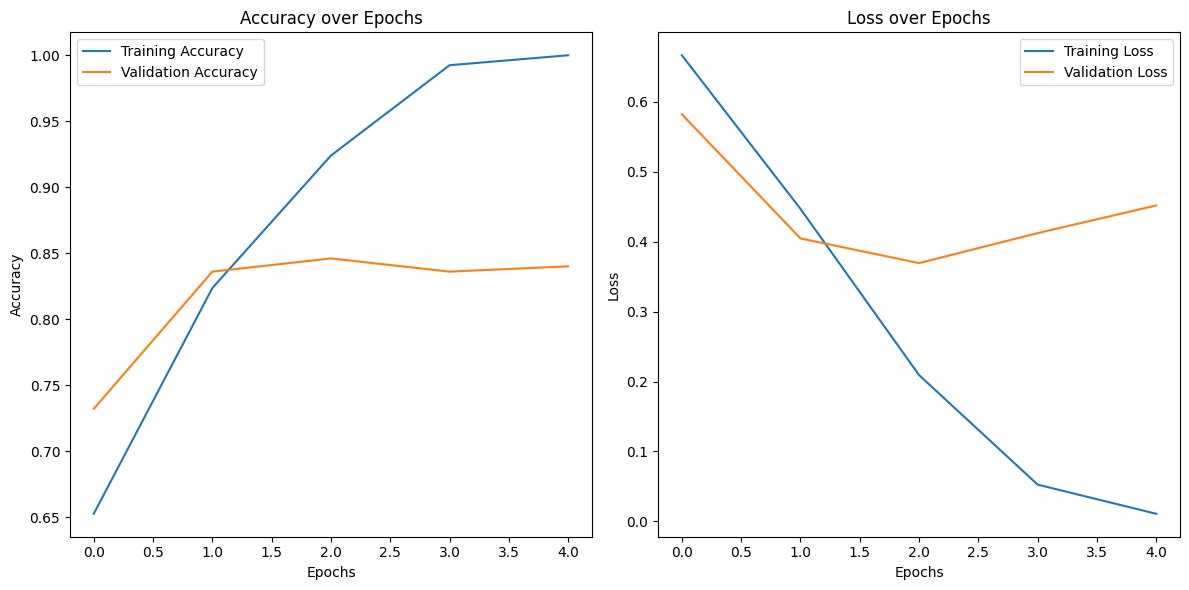

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

#plot accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#Display the plots
plt.tight_layout()
plt.show()

# **9. Classification Report**

In [15]:
import seaborn as sns
y_pred=model.predict(x_test)
y_pred=(y_pred>0.5).astype(int)

print("Classification report:")
print(classification_report(y_test,y_pred))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       251
           1       0.83      0.85      0.84       249

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500



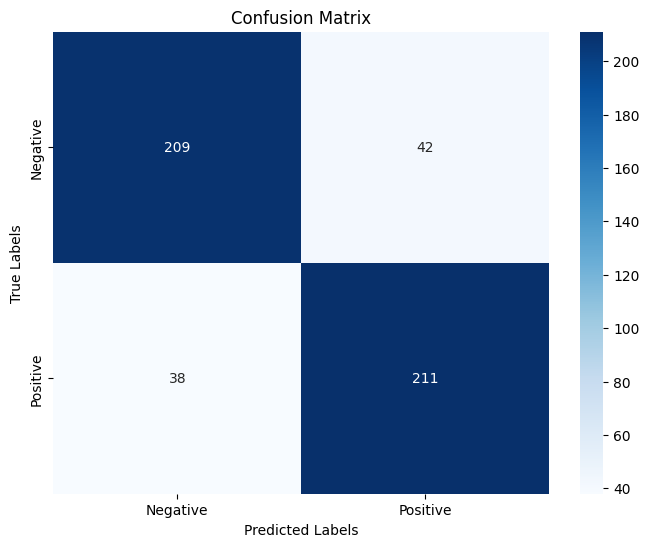

In [16]:
conf_matrix=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# **10. Predict Script**

In [17]:
def predict_sentiment(review,tokenizer,model,maxlen):
  text=clean_review_with_stopwords_and_stemming(review)

  sequence=tokenizer.texts_to_sequences([text])
  padded_sequence=pad_sequences(sequence,padding='post',maxlen=maxlen)

  prediction=model.predict(padded_sequence)[0][0]

  if prediction>0.5:
    return "Positive"
  else:
    return "Negative"

In [19]:
input="This movie was bad!"
predict_sentiment(input,tokenizer,model,maxlen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


'Negative'

# **11. save model,tokenizer**

In [20]:
model.save("/content/drive/MyDrive/models/sentiment_cnn_model.h5")

import pickle
pickle.dump(tokenizer,open("/content/drive/MyDrive/models/tokenizer.pkl","wb"))